##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Shape Constraints with Tensorflow Lattice


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lattice/tutorials/shape_constraints"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/lattice/blob/master/docs/tutorials/shape_constraints.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/lattice/blob/master/docs/tutorials/shape_constraints.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/lattice/docs/tutorials/shape_constraints.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

This tutorial is an overview of the constraints and regularizers provided by the TensorFlow Lattice (TFL) library. Here we use TFL premade models on synthetic datasets, but note that everything in this tutorial can also be done with models constructed from TFL Keras layers.

Before proceeding, make sure your runtime has all required packages installed (as imported in the code cells below).

## Setup

Installing TF Lattice package:

In [2]:
#@test {"skip": true}
!pip install -U tensorflow tf-keras tensorflow-lattice pydot graphviz
!pip install -U tensorflow_decision_forests

  Using cached tensorflow_lattice-2.1.1-py2.py3-none-any.whl.metadata (1.8 kB)


  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)


Using cached tensorflow_lattice-2.1.1-py2.py3-none-any.whl (219 kB)
Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)


Importing required packages:

In [3]:
import tensorflow as tf
import tensorflow_lattice as tfl
import tensorflow_decision_forests as tfdf

from IPython.core.pylabtools import figsize
import functools
import logging
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sys
import tempfile
logging.disable(sys.maxsize)

2024-12-15 12:16:17.652728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734264977.676108   13137 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734264977.683272   13137 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Use Keras 2.
version_fn = getattr(tf.keras, "version", None)
if version_fn and version_fn().startswith("3."):
  import tf_keras as keras
else:
  keras = tf.keras

Default values used in this guide:

In [5]:
NUM_EPOCHS = 1000
BATCH_SIZE = 64
LEARNING_RATE=0.01

## Training Dataset for Ranking Restaurants

Imagine a simplified scenario where we want to determine whether or not users will click on a restaurant search result. The task is to predict the clickthrough rate (CTR) given input features:
- Average rating (`avg_rating`): a numeric feature with values in the range [1,5].
- Number of reviews (`num_reviews`): a numeric feature with values capped at 200, which we use as a measure of trendiness.
- Dollar rating (`dollar_rating`): a categorical feature with string values in the set {"D", "DD", "DDD", "DDDD"}.

Here we create a synthetic dataset where the true CTR is given by the formula:
$$
CTR = 1 / (1 + exp\{\mbox{b(dollar_rating)}-\mbox{avg_rating}\times log(\mbox{num_reviews}) /4 \})
$$
where $b(\cdot)$ translates each `dollar_rating` to a baseline value:
$$
\mbox{D}\to 3,\ \mbox{DD}\to 2,\ \mbox{DDD}\to 4,\ \mbox{DDDD}\to 4.5.
$$

This formula reflects typical user patterns. e.g. given everything else fixed, users prefer restaurants with higher star ratings, and "\\$\\$" restaurants will receive more clicks than "\\$", followed by "\\$\\$\\$" and "\\$\\$\\$\\$".

In [6]:
dollar_ratings_vocab = ["D", "DD", "DDD", "DDDD"]
def click_through_rate(avg_ratings, num_reviews, dollar_ratings):
  dollar_rating_baseline = {"D": 3, "DD": 2, "DDD": 4, "DDDD": 4.5}
  return 1 / (1 + np.exp(
      np.array([dollar_rating_baseline[d] for d in dollar_ratings]) -
      avg_ratings * np.log1p(num_reviews) / 4))

Let's take a look at the contour plots of this CTR function.

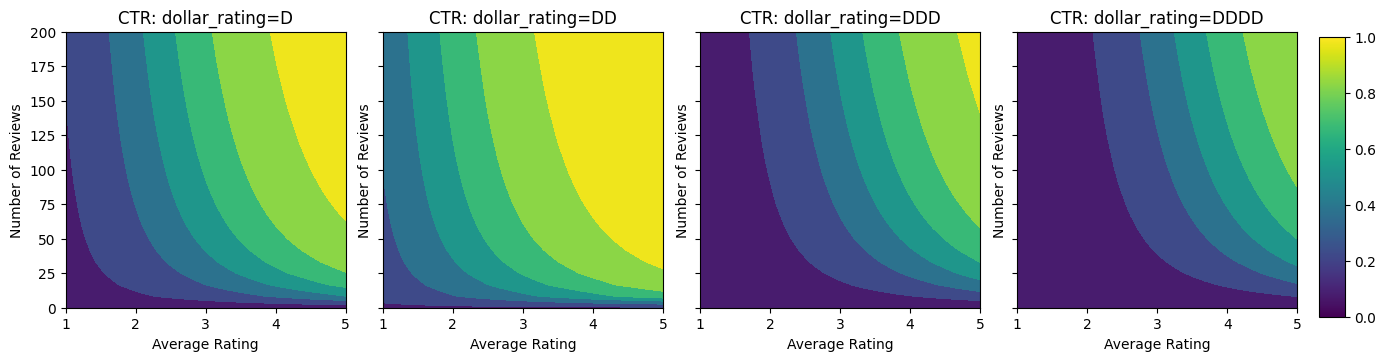

In [7]:
def color_bar():
  bar = matplotlib.cm.ScalarMappable(
      norm=matplotlib.colors.Normalize(0, 1, True),
      cmap="viridis",
  )
  bar.set_array([0, 1])
  return bar


def plot_fns(fns, res=25):
  """Generates contour plots for a list of (name, fn) functions."""
  num_reviews, avg_ratings = np.meshgrid(
      np.linspace(0, 200, num=res),
      np.linspace(1, 5, num=res),
  )
  figsize(13, 3.5 * len(fns))
  fig, axes = plt.subplots(
      len(fns), len(dollar_ratings_vocab), sharey=True, layout="constrained"
  )
  axes = axes.flatten()
  axes_index = 0
  for fn_name, fn in fns:
    for dollar_rating_split in dollar_ratings_vocab:
      dollar_ratings = np.repeat(dollar_rating_split, res**2)
      values = fn(avg_ratings.flatten(), num_reviews.flatten(), dollar_ratings)
      title = "{}: dollar_rating={}".format(fn_name, dollar_rating_split)
      subplot = axes[axes_index]
      axes_index += 1
      subplot.contourf(
          avg_ratings,
          num_reviews,
          np.reshape(values, (res, res)),
          vmin=0,
          vmax=1,
      )
      subplot.title.set_text(title)
      subplot.set(xlabel="Average Rating")
      subplot.set(ylabel="Number of Reviews")
      subplot.set(xlim=(1, 5))

  if len(fns) <= 2:
    cax = fig.add_axes([
        axes[-1].get_position().x1 + 0.11,
        axes[-1].get_position().y0,
        0.02,
        0.8,
    ])
    _ = fig.colorbar(color_bar(), cax=cax)


plot_fns([("CTR", click_through_rate)])

### Preparing Data


We now need to create our synthetic datasets. We start by generating a simulated dataset of restaurants and their features.

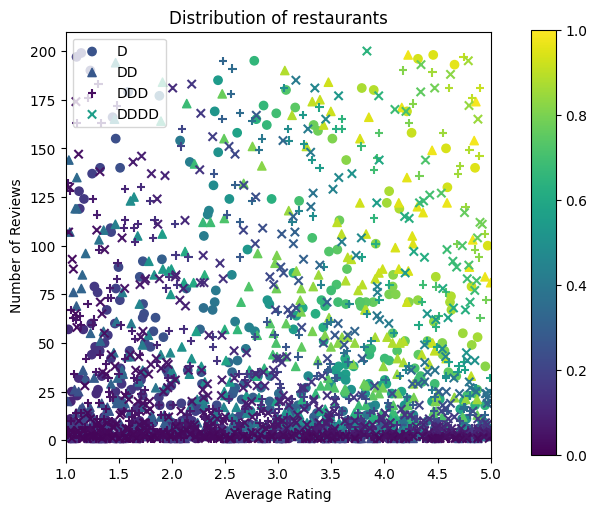

In [8]:
def sample_restaurants(n):
  avg_ratings = np.random.uniform(1.0, 5.0, n)
  num_reviews = np.round(np.exp(np.random.uniform(0.0, np.log(200), n)))
  dollar_ratings = np.random.choice(dollar_ratings_vocab, n)
  ctr_labels = click_through_rate(avg_ratings, num_reviews, dollar_ratings)
  return avg_ratings, num_reviews, dollar_ratings, ctr_labels


np.random.seed(42)
avg_ratings, num_reviews, dollar_ratings, ctr_labels = sample_restaurants(2000)

figsize(5, 5)
fig, axs = plt.subplots(1, 1, sharey=False, layout="constrained")

for rating, marker in [("D", "o"), ("DD", "^"), ("DDD", "+"), ("DDDD", "x")]:
  plt.scatter(
      x=avg_ratings[np.where(dollar_ratings == rating)],
      y=num_reviews[np.where(dollar_ratings == rating)],
      c=ctr_labels[np.where(dollar_ratings == rating)],
      vmin=0,
      vmax=1,
      marker=marker,
      label=rating)
plt.xlabel("Average Rating")
plt.ylabel("Number of Reviews")
plt.legend()
plt.xlim((1, 5))
plt.title("Distribution of restaurants")
_ = fig.colorbar(color_bar(), cax=fig.add_axes([1.05, 0.1, 0.05, 0.85]))

Let's produce the training, validation and testing datasets. When a restaurant is viewed in the search results, we can record user's engagement (click or no click) as a sample point.

In practice, users often do not go through all search results. This means that users will likely only see restaurants already considered "good" by the current ranking model in use. As a result, "good" restaurants are more frequently impressed and over-represented in the training datasets. When using more features, the training dataset can have large gaps in "bad" parts of the feature space.

When the model is used for ranking, it is often evaluated on all relevant results with a more uniform distribution that is not well-represented by the training dataset. A flexible and complicated model might fail in this case due to overfitting the over-represented data points and thus lack generalizability. We handle this issue by applying domain knowledge to add *shape constraints* that guide the model to make reasonable predictions when it cannot pick them up from the training dataset.

In this example, the training dataset mostly consists of user interactions with good and popular restaurants. The testing dataset has a uniform distribution to simulate the evaluation setting discussed above. Note that such testing dataset will not be available in a real problem setting.

2024-12-15 12:16:22.116657: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


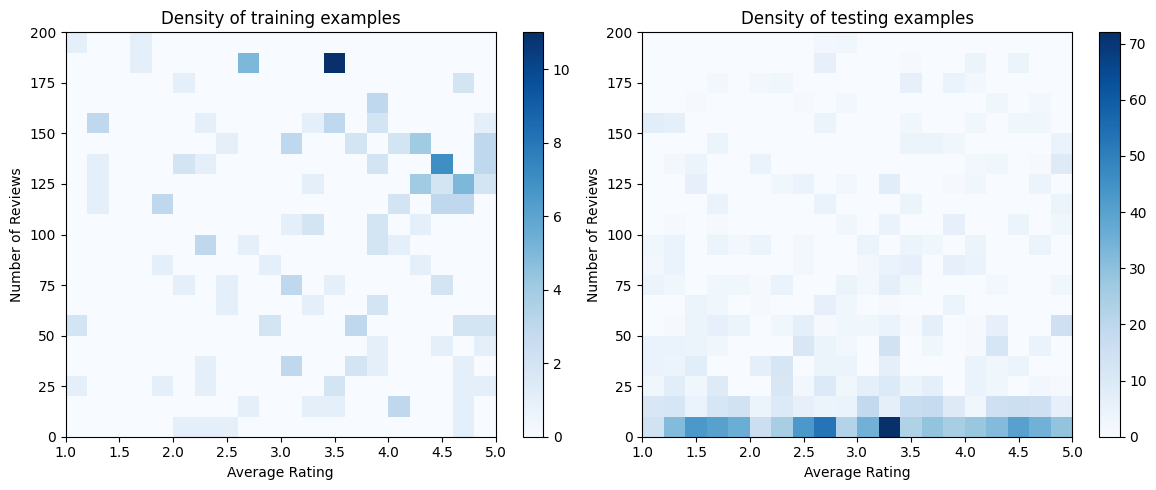

In [9]:
def sample_dataset(n, testing_set):
  (avg_ratings, num_reviews, dollar_ratings, ctr_labels) = sample_restaurants(n)
  if testing_set:
    # Testing has a more uniform distribution over all restaurants.
    num_views = np.random.poisson(lam=3, size=n)
  else:
    # Training/validation datasets have more views on popular restaurants.
    num_views = np.random.poisson(lam=ctr_labels * num_reviews / 50.0, size=n)

  return pd.DataFrame({
      "avg_rating": np.repeat(avg_ratings, num_views),
      "num_reviews": np.repeat(num_reviews, num_views),
      "dollar_rating": np.repeat(dollar_ratings, num_views),
      "clicked": np.random.binomial(n=1, p=np.repeat(ctr_labels, num_views)),
  })


# Generate datasets.
np.random.seed(42)
data_train = sample_dataset(500, testing_set=False)
data_val = sample_dataset(500, testing_set=False)
data_test = sample_dataset(500, testing_set=True)

ds_train = tfdf.keras.pd_dataframe_to_tf_dataset(
    data_train, label="clicked", batch_size=BATCH_SIZE
)
ds_val = tfdf.keras.pd_dataframe_to_tf_dataset(
    data_val, label="clicked", batch_size=BATCH_SIZE
)
ds_test = tfdf.keras.pd_dataframe_to_tf_dataset(
    data_test, label="clicked", batch_size=BATCH_SIZE
)

# feature_analysis_data is used to find quantiles of featurse.
feature_analysis_data = data_train.copy()
feature_analysis_data["dollar_rating"] = feature_analysis_data[
    "dollar_rating"
].map({v: i for i, v in enumerate(dollar_ratings_vocab)})
feature_analysis_data = dict(feature_analysis_data)

# Plotting dataset densities.
figsize(12, 5)
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=False)
for ax, data, title in [
    (axs[0], data_train, "training"),
    (axs[1], data_test, "testing"),
]:
  _, _, _, density = ax.hist2d(
      x=data["avg_rating"],
      y=data["num_reviews"],
      bins=(np.linspace(1, 5, num=21), np.linspace(0, 200, num=21)),
      cmap="Blues",
  )
  ax.set(xlim=(1, 5))
  ax.set(ylim=(0, 200))
  ax.set(xlabel="Average Rating")
  ax.set(ylabel="Number of Reviews")
  ax.title.set_text("Density of {} examples".format(title))
  _ = fig.colorbar(density, ax=ax)

## Fitting Gradient Boosted Trees

We first create a few auxillary functions for plotting and calculating validation and test metrics.

In [10]:
def pred_fn(model, from_logits, avg_ratings, num_reviews, dollar_rating):
  preds = model.predict(
      tf.data.Dataset.from_tensor_slices({
          "avg_rating": avg_ratings,
          "num_reviews": num_reviews,
          "dollar_rating": dollar_rating,
      }).batch(1),
      verbose=0,
  )
  if from_logits:
    preds = tf.math.sigmoid(preds)
  return preds


def analyze_model(models, from_logits=False, print_metrics=True):
  pred_fns = []
  for model, name in models:
    if print_metrics:
      metric = model.evaluate(ds_val, return_dict=True, verbose=0)
      print("Validation AUC: {}".format(metric["auc"]))
      metric = model.evaluate(ds_test, return_dict=True, verbose=0)
      print("Testing AUC: {}".format(metric["auc"]))

    pred_fns.append(
        ("{} pCTR".format(name), functools.partial(pred_fn, model, from_logits))
    )

  pred_fns.append(("CTR", click_through_rate))
  plot_fns(pred_fns)

We can fit TensorFlow gradient boosted decision trees on the dataset:

2024-12-15 12:16:22.937245: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2024-12-15 12:16:22.937282: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2024-12-15 12:16:22.937290: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(155, shape=(), dtype=int32)


I0000 00:00:1734264987.120228   13137 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1734264987.120285   13137 kernel.cc:783] Collect training examples
I0000 00:00:1734264987.120293   13137 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
column_guides {
  column_name_pattern: "^num_reviews$"
}
column_guides {
  column_name_pattern: "^avg_rating$"
}
column_guides {
  column_name_pattern: "^dollar_rating$"
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: true
detect_numerical_as_discretized_numerical: false

I0000 00:00:1734264987.120673   13137 kernel.cc:401] Number of batches: 3
I0000 00:00:1734264987.120684   13137 kernel.cc:402] Number of examples: 162
I0000 00:00:1734264987.120732   13137 kernel.cc:802] Training dataset:
Number of records: 

Validation AUC: 0.7145258188247681
Testing AUC: 0.8356180191040039


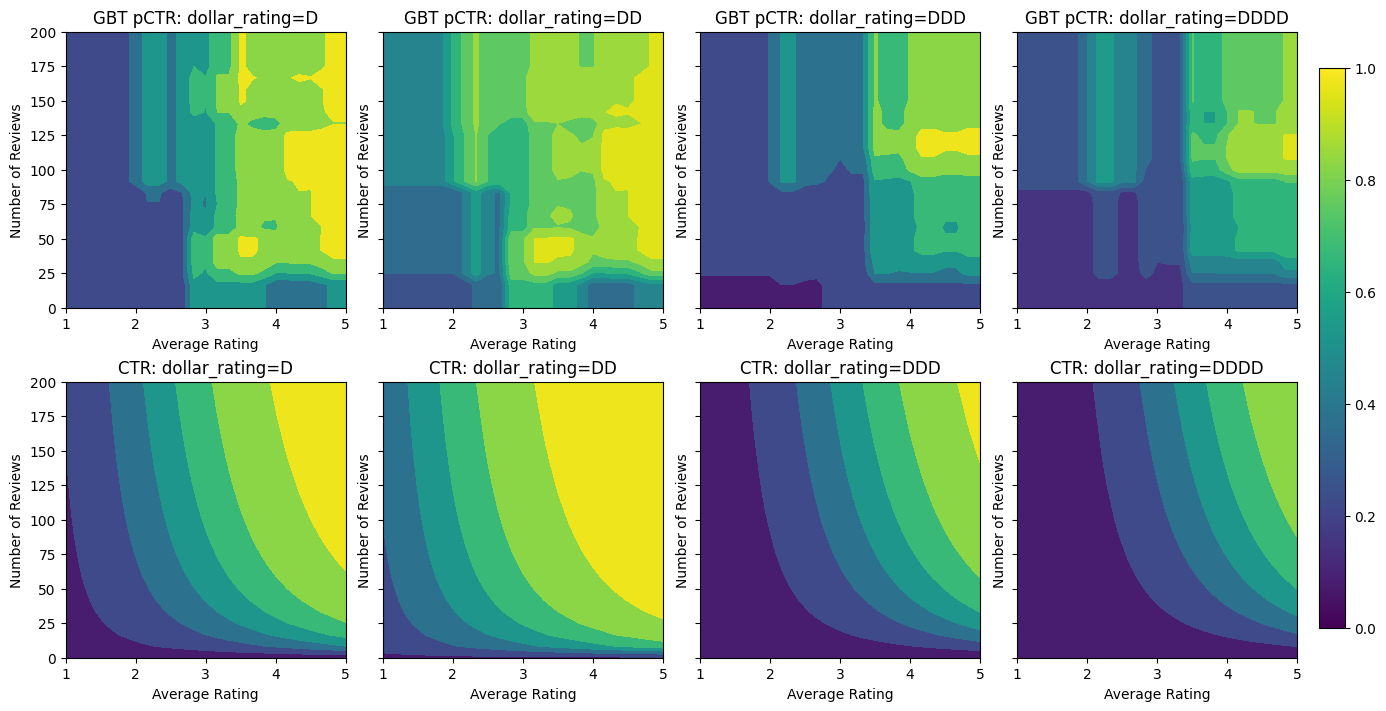

In [11]:
gbt_model = tfdf.keras.GradientBoostedTreesModel(
    features=[
        tfdf.keras.FeatureUsage(name="num_reviews"),
        tfdf.keras.FeatureUsage(name="avg_rating"),
        tfdf.keras.FeatureUsage(name="dollar_rating"),
    ],
    exclude_non_specified_features=True,
    num_threads=1,
    num_trees=32,
    max_depth=6,
    min_examples=10,
    growing_strategy="BEST_FIRST_GLOBAL",
    random_seed=42,
    temp_directory=tempfile.mkdtemp(),
)
gbt_model.compile(metrics=[keras.metrics.AUC(name="auc")])
gbt_model.fit(ds_train, validation_data=ds_val, verbose=0)
analyze_model([(gbt_model, "GBT")])

Even though the model has captured the general shape of the true CTR and has decent validation metrics, it has counter-intuitive behavior in several parts of the input space: the estimated CTR decreases as the average rating or number of reviews increase. This is due to a lack of sample points in areas not well-covered by the training dataset. The model simply has no way to deduce the correct behaviour solely from the data.

To solve this issue, we enforce the shape constraint that the model must output values monotonically increasing with respect to both the average rating and the number of reviews. We will later see how to implement this in TFL.


## Fitting a DNN

We can repeat the same steps with a DNN classifier. We can observe a similar pattern: not having enough sample points with small number of reviews results in nonsensical extrapolation.

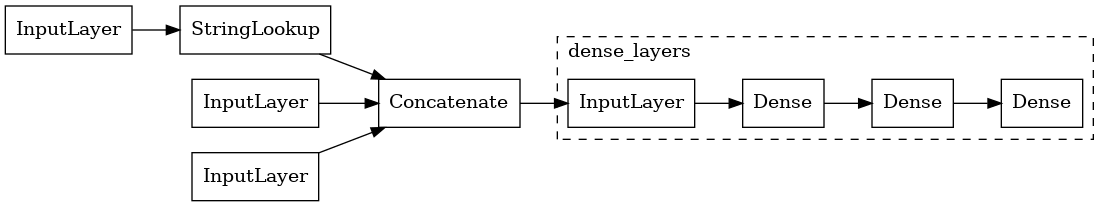

In [12]:
keras.utils.set_random_seed(42)
inputs = {
    "num_reviews": keras.Input(shape=(1,), dtype=tf.float32),
    "avg_rating": keras.Input(shape=(1), dtype=tf.float32),
    "dollar_rating": keras.Input(shape=(1), dtype=tf.string),
}
inputs_flat = keras.layers.Concatenate()([
    inputs["num_reviews"],
    inputs["avg_rating"],
    keras.layers.StringLookup(
        vocabulary=dollar_ratings_vocab,
        num_oov_indices=0,
        output_mode="one_hot",
    )(inputs["dollar_rating"]),
])
dense_layers = keras.Sequential(
    [
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dense(1, activation=None),
    ],
    name="dense_layers",
)
dnn_model = keras.Model(inputs=inputs, outputs=dense_layers(inputs_flat))
keras.utils.plot_model(
    dnn_model, expand_nested=True, show_layer_names=False, rankdir="LR"
)

Validation AUC: 0.7568147778511047
Testing AUC: 0.8183510899543762


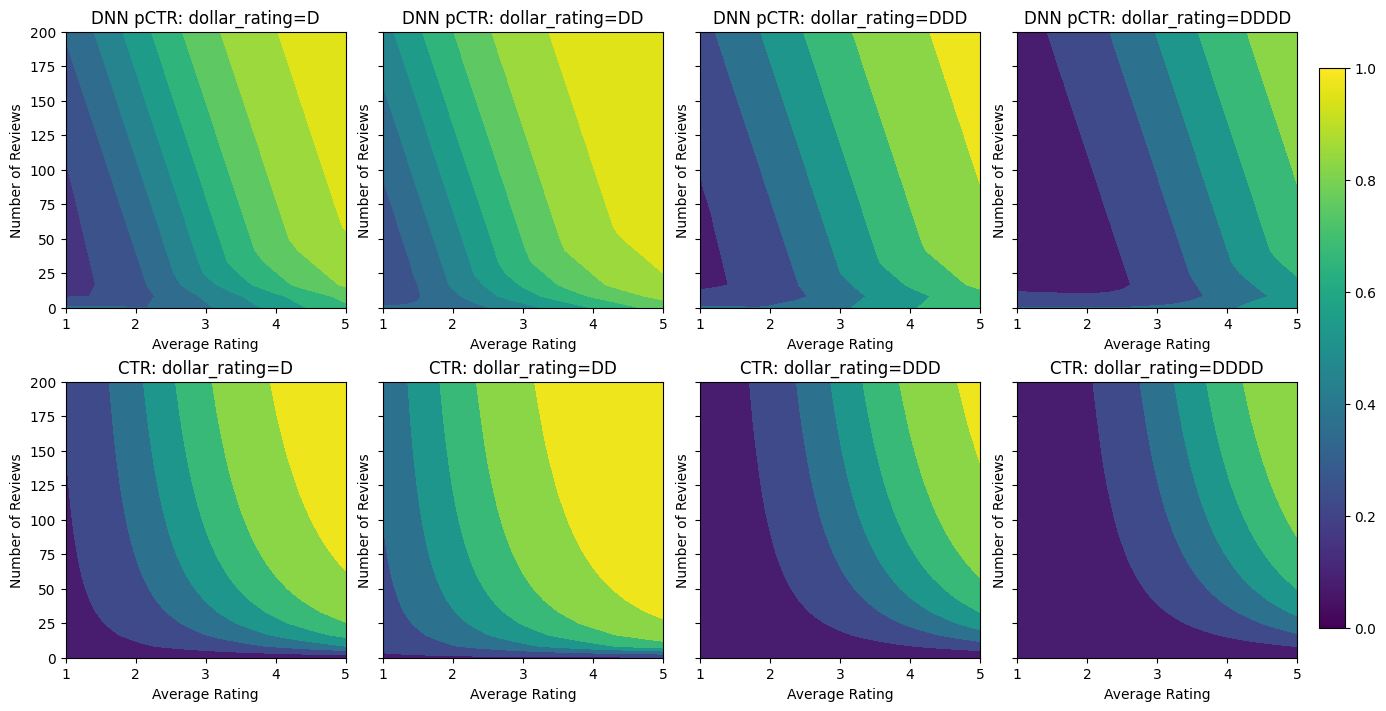

In [13]:
dnn_model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.AUC(from_logits=True, name="auc")],
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
)
dnn_model.fit(ds_train, epochs=200, verbose=0)
analyze_model([(dnn_model, "DNN")], from_logits=True)

## Shape Constraints

TensorFlow Lattice (TFL) is focused on enforcing shape constraints to safeguard model behavior beyond the training data. These shape constraints are applied to TFL Keras layers. Their details can be found in [our JMLR paper](http://jmlr.org/papers/volume17/15-243/15-243.pdf).

In this tutorial we use TF premade models to cover various shape constraints, but note that all these steps can be done with models created from TFL Keras layers.

Using TFL premade models also requires:
- a *model config*: defining the model architecture and per-feature shape constraints and regularizers.
- a *feature analysis dataset*: a dataset used for TFL initialization (feature quantile calcuation).

For a more thorough description, please refer to the premade models or the API docs.

### Monotonicity
We first address the monotonicity concerns by adding monotonicity shape constraints to the continuous features. We use a calibrated lattice model with added output calibration: each feature is calibrated using categorical or piecewise-linear calibrators, then fed into a lattice model, followed by an output piecewise-linear calibrator.

To instruct TFL to enforce shape constraints, we specify the constraints in the *feature configs*. The following code shows how we can require the output to be monotonically increasing with respect to both `num_reviews` and `avg_rating` by setting `monotonicity="increasing"`.


In [14]:
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=[
        tfl.configs.FeatureConfig(
            name="num_reviews",
            lattice_size=3,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=32,
        ),
        tfl.configs.FeatureConfig(
            name="avg_rating",
            lattice_size=3,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=32,
        ),
        tfl.configs.FeatureConfig(
            name="dollar_rating",
            lattice_size=3,
            pwl_calibration_num_keypoints=4,
            vocabulary_list=dollar_ratings_vocab,
            num_buckets=len(dollar_ratings_vocab),
        ),
    ],
    output_calibration=True,
    output_initialization=np.linspace(-2, 2, num=5),
)

We now use the `feature_analysis_data` to find and set the quantile values for the input features. These values can be pre-calculated and set explicitly in the feature config depending on the training pipeline.

In [15]:
feature_analysis_data = data_train.copy()
feature_analysis_data["dollar_rating"] = feature_analysis_data[
    "dollar_rating"
].map({v: i for i, v in enumerate(dollar_ratings_vocab)})
feature_analysis_data = dict(feature_analysis_data)

feature_keypoints = tfl.premade_lib.compute_feature_keypoints(
    feature_configs=model_config.feature_configs, features=feature_analysis_data
)
tfl.premade_lib.set_feature_keypoints(
    feature_configs=model_config.feature_configs,
    feature_keypoints=feature_keypoints,
    add_missing_feature_configs=False,
)

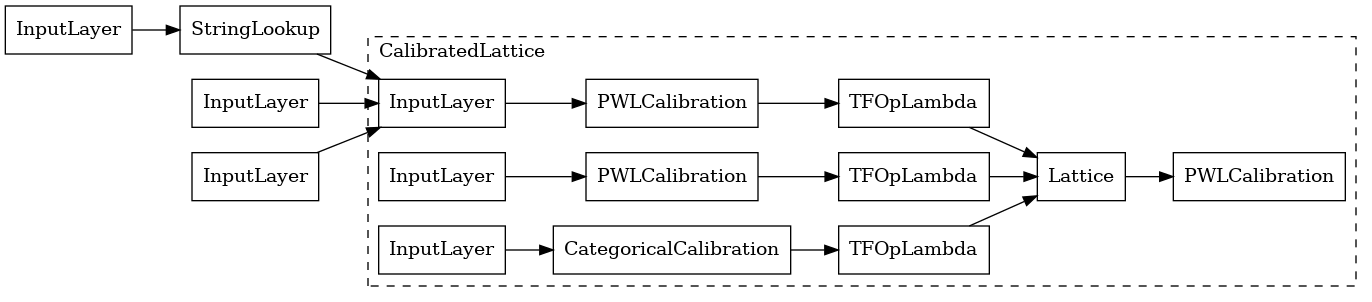

In [16]:
keras.utils.set_random_seed(42)
inputs = {
    "num_reviews": keras.Input(shape=(1,), dtype=tf.float32),
    "avg_rating": keras.Input(shape=(1), dtype=tf.float32),
    "dollar_rating": keras.Input(shape=(1), dtype=tf.string),
}
ordered_inputs = [
    inputs["num_reviews"],
    inputs["avg_rating"],
    keras.layers.StringLookup(
        vocabulary=dollar_ratings_vocab,
        num_oov_indices=0,
        output_mode="int",
    )(inputs["dollar_rating"]),
]
outputs = tfl.premade.CalibratedLattice(
    model_config=model_config, name="CalibratedLattice"
)(ordered_inputs)
tfl_model_0 = keras.Model(inputs=inputs, outputs=outputs)

keras.utils.plot_model(
    tfl_model_0, expand_nested=True, show_layer_names=False, rankdir="LR"
)

Using a `CalibratedLatticeConfig` creates a premade classifier that first applies a *calibrator* to each input (a piece-wise linear function for numeric features) followed by a *lattice* layer to non-linearly fuse the calibrated features. We have also enabled output piece-wise linear calibration.


Validation AUC: 0.7199402451515198
Testing AUC: 0.798313558101654


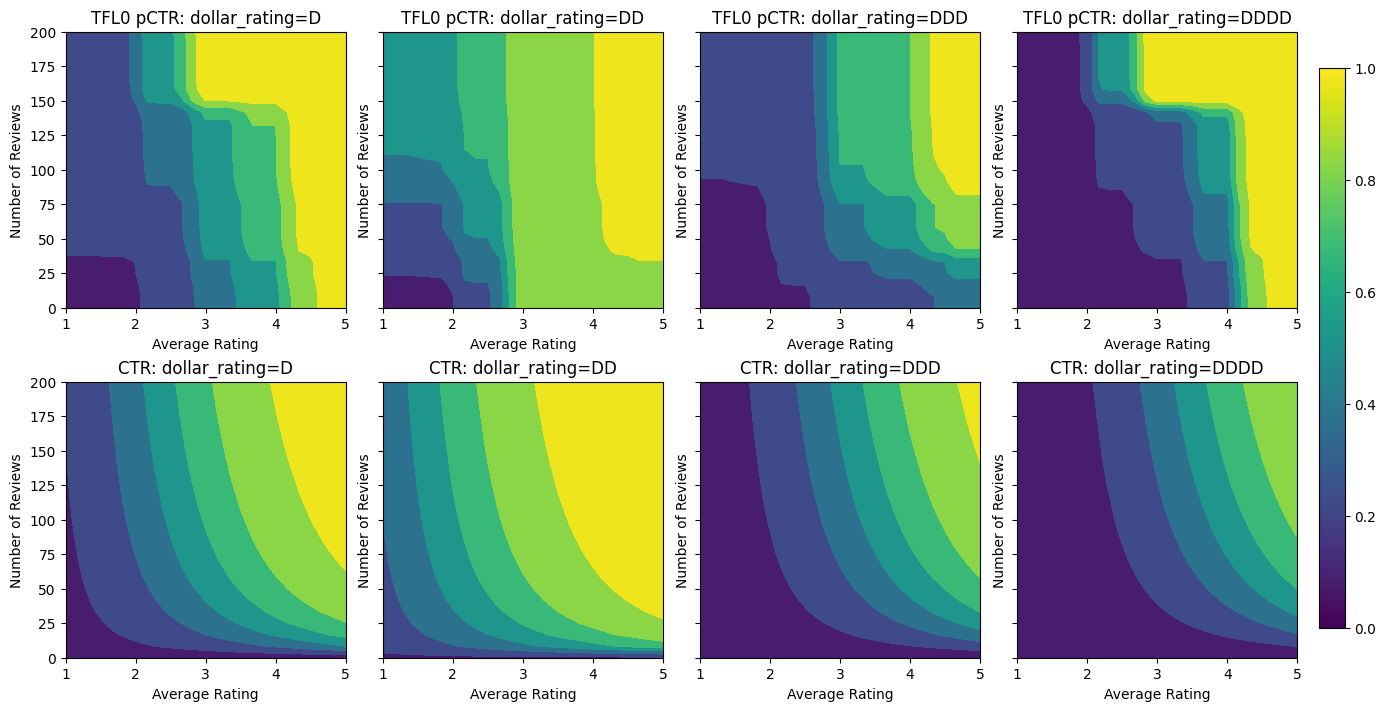

In [17]:
tfl_model_0.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.AUC(from_logits=True, name="auc")],
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
)
tfl_model_0.fit(ds_train, epochs=100, verbose=0)
analyze_model([(tfl_model_0, "TFL0")], from_logits=True)

With the constraints added, the estimated CTR will always increase as the average rating increases or the number of reviews increases. This is done by making sure that the calibrators and the lattice are monotonic.

### Partial Monotonicity for Categorical Calibration


To use constraints on the third feature, `dollar_rating`, we should recall that categorical features require a slightly different treatment in TFL. Here we enforce the partial monotonicity constraint that outputs for "DD" restaurants should be larger than "D" restaurants when all other inputs are fixed. This is done using the `monotonicity` setting in the feature config. We also need to use `tfl.premade_lib.set_categorical_monotonicities` to convert the constrains specified in string values into the numerical format understood by the library.

Validation AUC: 0.741411566734314
Testing AUC: 0.8500608205795288


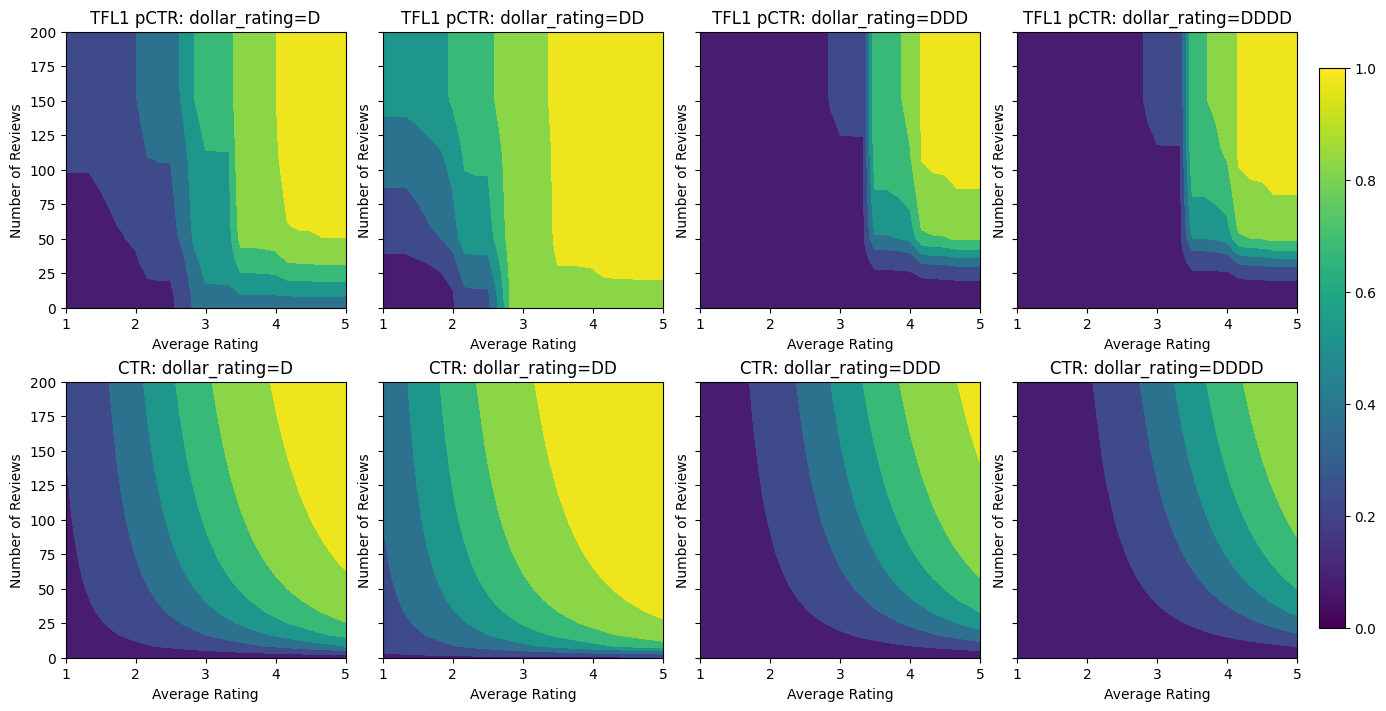

In [18]:
keras.utils.set_random_seed(42)
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=[
        tfl.configs.FeatureConfig(
            name="num_reviews",
            lattice_size=3,
            monotonicity="increasing",
            pwl_calibration_convexity="concave",
            pwl_calibration_num_keypoints=32,
        ),
        tfl.configs.FeatureConfig(
            name="avg_rating",
            lattice_size=3,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=32,
        ),
        tfl.configs.FeatureConfig(
            name="dollar_rating",
            lattice_size=3,
            pwl_calibration_num_keypoints=4,
            vocabulary_list=dollar_ratings_vocab,
            num_buckets=len(dollar_ratings_vocab),
            monotonicity=[("D", "DD")],
        ),
    ],
    output_calibration=True,
    output_initialization=np.linspace(-2, 2, num=5),
)

tfl.premade_lib.set_feature_keypoints(
    feature_configs=model_config.feature_configs,
    feature_keypoints=feature_keypoints,
    add_missing_feature_configs=False,
)
tfl.premade_lib.set_categorical_monotonicities(model_config.feature_configs)

outputs = tfl.premade.CalibratedLattice(
    model_config=model_config, name="CalibratedLattice"
)(ordered_inputs)
tfl_model_1 = keras.Model(inputs=inputs, outputs=outputs)
tfl_model_1.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.AUC(from_logits=True, name="auc")],
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
)
tfl_model_1.fit(ds_train, epochs=100, verbose=0)
analyze_model([(tfl_model_1, "TFL1")], from_logits=True)

Here we also plot the predicted CTR of this model conditioned on `dollar_rating`. Notice that all the constraints we required are fulfilled in each of the slices.

### 2D Shape Constraint: Trust
A 5-star rating for a restaurant with only one or two reviews is likely an unreliable rating (the restaurant might not actually be good), whereas a 4-star rating for a restaurant with hundreds of reviews is much more reliable (the restaurant is likely good in this case). We can see that the number of reviews of a restaurant affects how much trust we place in its average rating.

We can exercise TFL trust constraints to inform the model that the larger (or smaller) value of one feature indicates more reliance or trust of another feature. This is done by setting `reflects_trust_in` configuration in the feature config.

Validation AUC: 0.774645209312439
Testing AUC: 0.8462862372398376


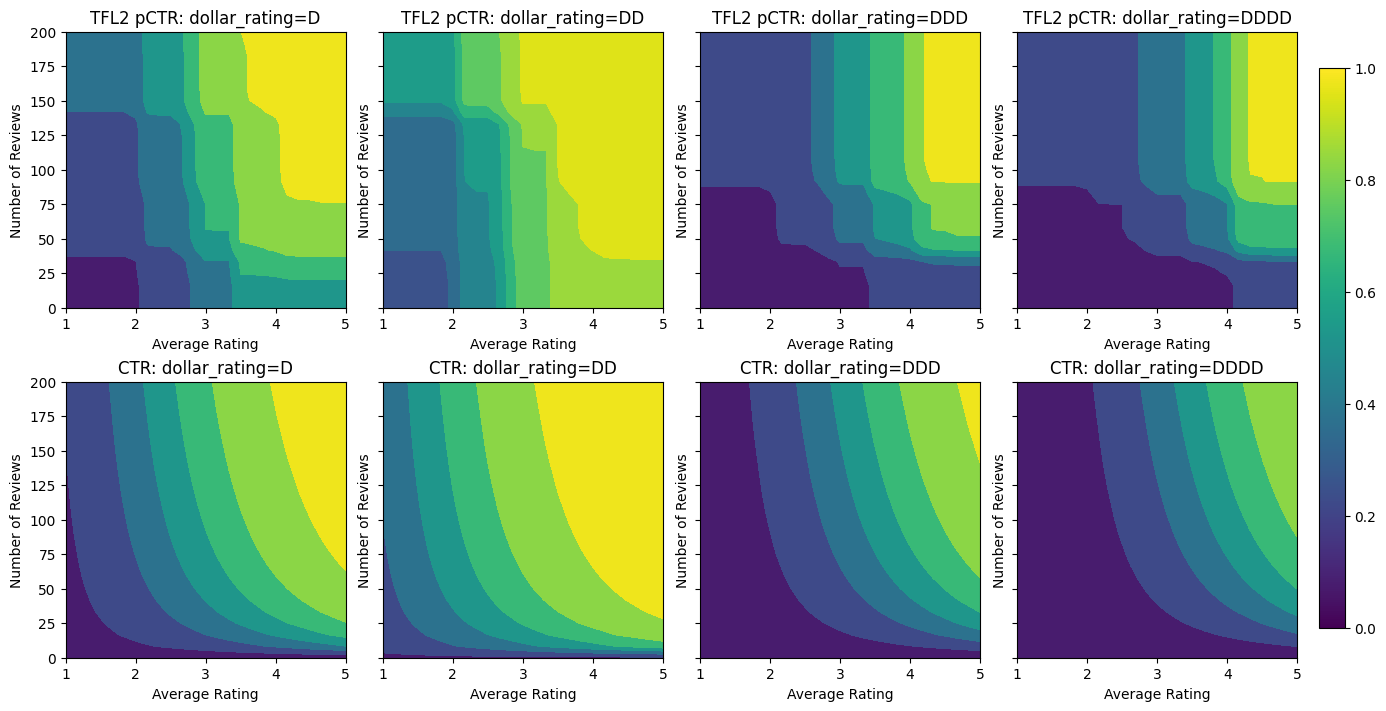

In [19]:
keras.utils.set_random_seed(42)
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=[
        tfl.configs.FeatureConfig(
            name="num_reviews",
            lattice_size=3,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=32,
            # Larger num_reviews indicating more trust in avg_rating.
            reflects_trust_in=[
                tfl.configs.TrustConfig(
                    feature_name="avg_rating", trust_type="edgeworth"
                ),
            ],
        ),
        tfl.configs.FeatureConfig(
            name="avg_rating",
            lattice_size=3,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=32,
        ),
        tfl.configs.FeatureConfig(
            name="dollar_rating",
            lattice_size=3,
            pwl_calibration_num_keypoints=4,
            vocabulary_list=dollar_ratings_vocab,
            num_buckets=len(dollar_ratings_vocab),
            monotonicity=[("D", "DD")],
        ),
    ],
    output_calibration=True,
    output_initialization=np.linspace(-2, 2, num=5),
)

tfl.premade_lib.set_feature_keypoints(
    feature_configs=model_config.feature_configs,
    feature_keypoints=feature_keypoints,
    add_missing_feature_configs=False,
)
tfl.premade_lib.set_categorical_monotonicities(model_config.feature_configs)

outputs = tfl.premade.CalibratedLattice(
    model_config=model_config, name="CalibratedLattice"
)(ordered_inputs)
tfl_model_2 = keras.Model(inputs=inputs, outputs=outputs)
tfl_model_2.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.AUC(from_logits=True, name="auc")],
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
)
tfl_model_2.fit(ds_train, epochs=100, verbose=0)
analyze_model([(tfl_model_2, "TFL2")], from_logits=True)

The following plot presents the trained lattice function. Due to the trust constraint, we expect that larger values of calibrated `num_reviews` would force higher slope with respect to calibrated `avg_rating`, resulting in a more significant move in the lattice output.

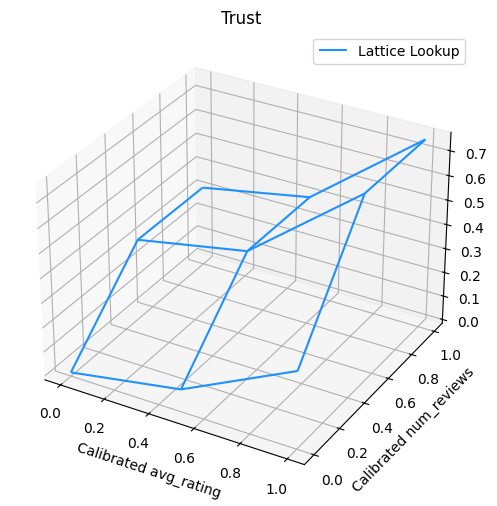

In [20]:
lattice_params = tfl_model_2.layers[-1].layers[-2].weights[0].numpy()
lat_mesh_x, lat_mesh_y = np.meshgrid(
    np.linspace(0, 1, num=3),
    np.linspace(0, 1, num=3),
)
lat_mesh_z = np.reshape(np.asarray(lattice_params[0::3]), (3, 3))

figure = plt.figure(figsize=(6, 6))
axes = figure.add_subplot(projection="3d")
axes.plot_wireframe(lat_mesh_x, lat_mesh_y, lat_mesh_z, color="dodgerblue")
plt.legend(["Lattice Lookup"])
plt.title("Trust")
plt.xlabel("Calibrated avg_rating")
plt.ylabel("Calibrated num_reviews")
plt.show()

### Diminishing Returns
[Diminishing returns](https://en.wikipedia.org/wiki/Diminishing_returns) means that the marginal gain of increasing a certain feature value will decrease as we increase the value. In our case we expect that the `num_reviews` feature follows this pattern, so we can configure its calibrator accordingly. Notice that we can decompose diminishing returns into two sufficient conditions:

- the calibrator is monotonicially increasing, and
- the calibrator is concave (setting `pwl_calibration_convexity="concave"`).


Validation AUC: 0.7506535053253174
Testing AUC: 0.8575603365898132


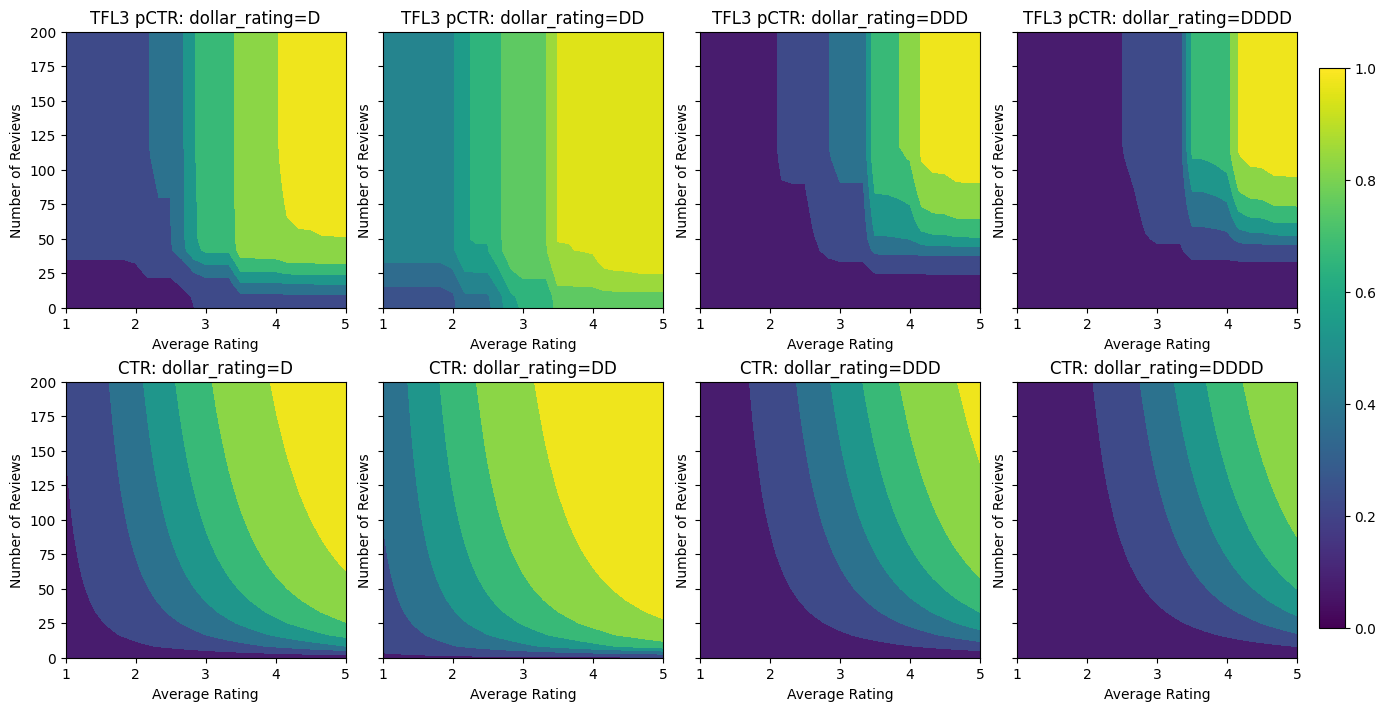

In [21]:
keras.utils.set_random_seed(42)
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=[
        tfl.configs.FeatureConfig(
            name="num_reviews",
            lattice_size=3,
            monotonicity="increasing",
            pwl_calibration_convexity="concave",
            pwl_calibration_num_keypoints=32,
            reflects_trust_in=[
                tfl.configs.TrustConfig(
                    feature_name="avg_rating", trust_type="edgeworth"
                ),
            ],
        ),
        tfl.configs.FeatureConfig(
            name="avg_rating",
            lattice_size=3,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=32,
        ),
        tfl.configs.FeatureConfig(
            name="dollar_rating",
            lattice_size=3,
            pwl_calibration_num_keypoints=4,
            vocabulary_list=dollar_ratings_vocab,
            num_buckets=len(dollar_ratings_vocab),
            monotonicity=[("D", "DD")],
        ),
    ],
    output_calibration=True,
    output_initialization=np.linspace(-2, 2, num=5),
)

tfl.premade_lib.set_feature_keypoints(
    feature_configs=model_config.feature_configs,
    feature_keypoints=feature_keypoints,
    add_missing_feature_configs=False,
)
tfl.premade_lib.set_categorical_monotonicities(model_config.feature_configs)

outputs = tfl.premade.CalibratedLattice(
    model_config=model_config, name="CalibratedLattice"
)(ordered_inputs)
tfl_model_3 = keras.Model(inputs=inputs, outputs=outputs)
tfl_model_3.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.AUC(from_logits=True, name="auc")],
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
)
tfl_model_3.fit(
    ds_train,
    epochs=100,
    verbose=0
)
analyze_model([(tfl_model_3, "TFL3")], from_logits=True)

Notice how the testing metric improves by adding the concavity constraint. The prediction plot also better resembles the ground truth.

### Smoothing Calibrators
We notice in the prediction curves above that even though the output is monotonic in specified features, the changes in the slopes are abrupt and hard to interpret. That suggests we might want to consider smoothing this calibrator using a regularizer setup in the `regularizer_configs`.

Here we apply a `hessian` regularizer to make the calibration more linear. You can also use the `laplacian` regularizer to flatten the calibrator and the `wrinkle` regularizer to reduce changes in the curvature.


Validation AUC: 0.7562546730041504
Testing AUC: 0.8593733310699463


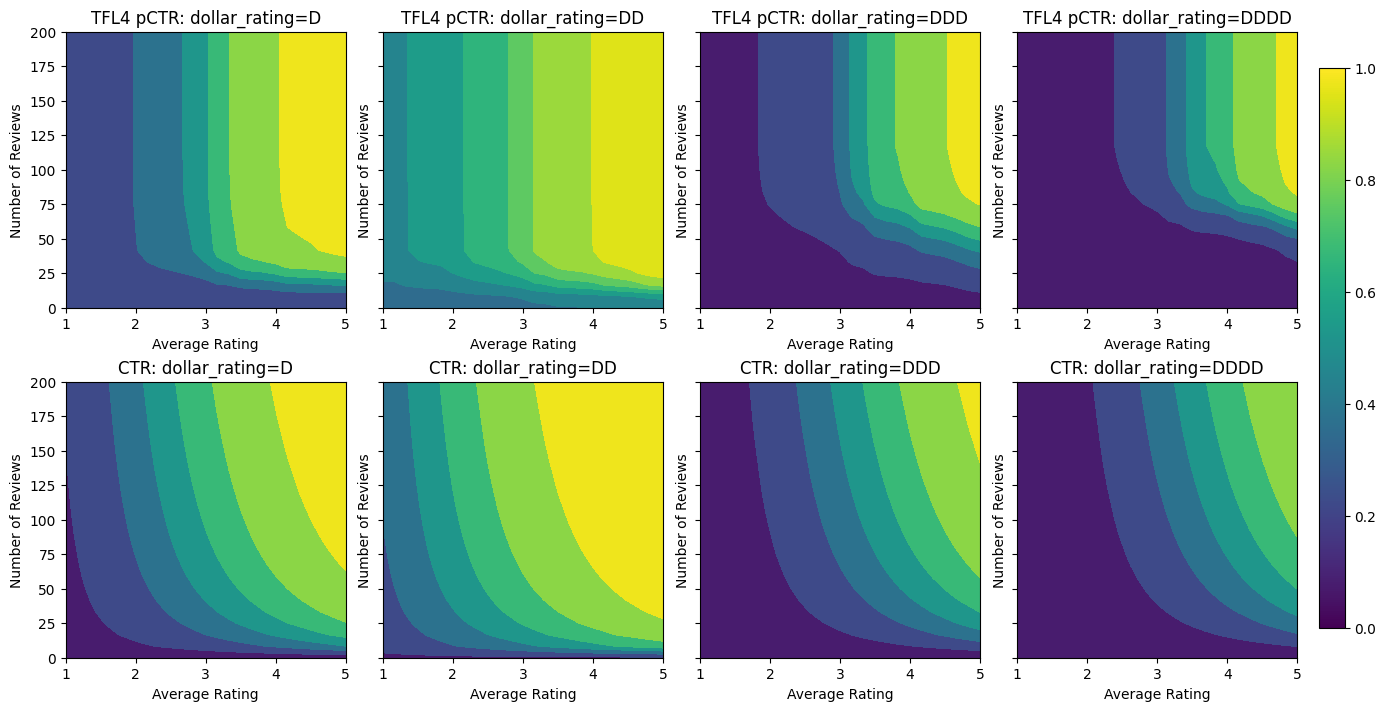

In [22]:
keras.utils.set_random_seed(42)
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=[
        tfl.configs.FeatureConfig(
            name="num_reviews",
            lattice_size=3,
            monotonicity="increasing",
            pwl_calibration_convexity="concave",
            pwl_calibration_num_keypoints=32,
            regularizer_configs=[
                tfl.configs.RegularizerConfig(name="calib_hessian", l2=0.5),
            ],
            reflects_trust_in=[
                tfl.configs.TrustConfig(
                    feature_name="avg_rating", trust_type="edgeworth"
                ),
            ],
        ),
        tfl.configs.FeatureConfig(
            name="avg_rating",
            lattice_size=3,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=32,
            regularizer_configs=[
                tfl.configs.RegularizerConfig(name="calib_hessian", l2=0.5),
            ],
        ),
        tfl.configs.FeatureConfig(
            name="dollar_rating",
            lattice_size=3,
            pwl_calibration_num_keypoints=4,
            vocabulary_list=dollar_ratings_vocab,
            num_buckets=len(dollar_ratings_vocab),
            monotonicity=[("D", "DD")],
        ),
    ],
    output_calibration=True,
    output_initialization=np.linspace(-2, 2, num=5),
    regularizer_configs=[
        tfl.configs.RegularizerConfig(name="calib_hessian", l2=0.1),
    ],
)

tfl.premade_lib.set_feature_keypoints(
    feature_configs=model_config.feature_configs,
    feature_keypoints=feature_keypoints,
    add_missing_feature_configs=False,
)
tfl.premade_lib.set_categorical_monotonicities(model_config.feature_configs)

outputs = tfl.premade.CalibratedLattice(
    model_config=model_config, name="CalibratedLattice"
)(ordered_inputs)
tfl_model_4 = keras.Model(inputs=inputs, outputs=outputs)
tfl_model_4.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.AUC(from_logits=True, name="auc")],
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
)
tfl_model_4.fit(ds_train, epochs=100, verbose=0)
analyze_model([(tfl_model_4, "TFL4")], from_logits=True)

The calibrators are now smooth, and the overall estimated CTR better matches the ground truth. This is reflected both in the testing metric and in the contour plots.

Here you can see the results of each step as we added domain-specific constraints and regularizers to the model.

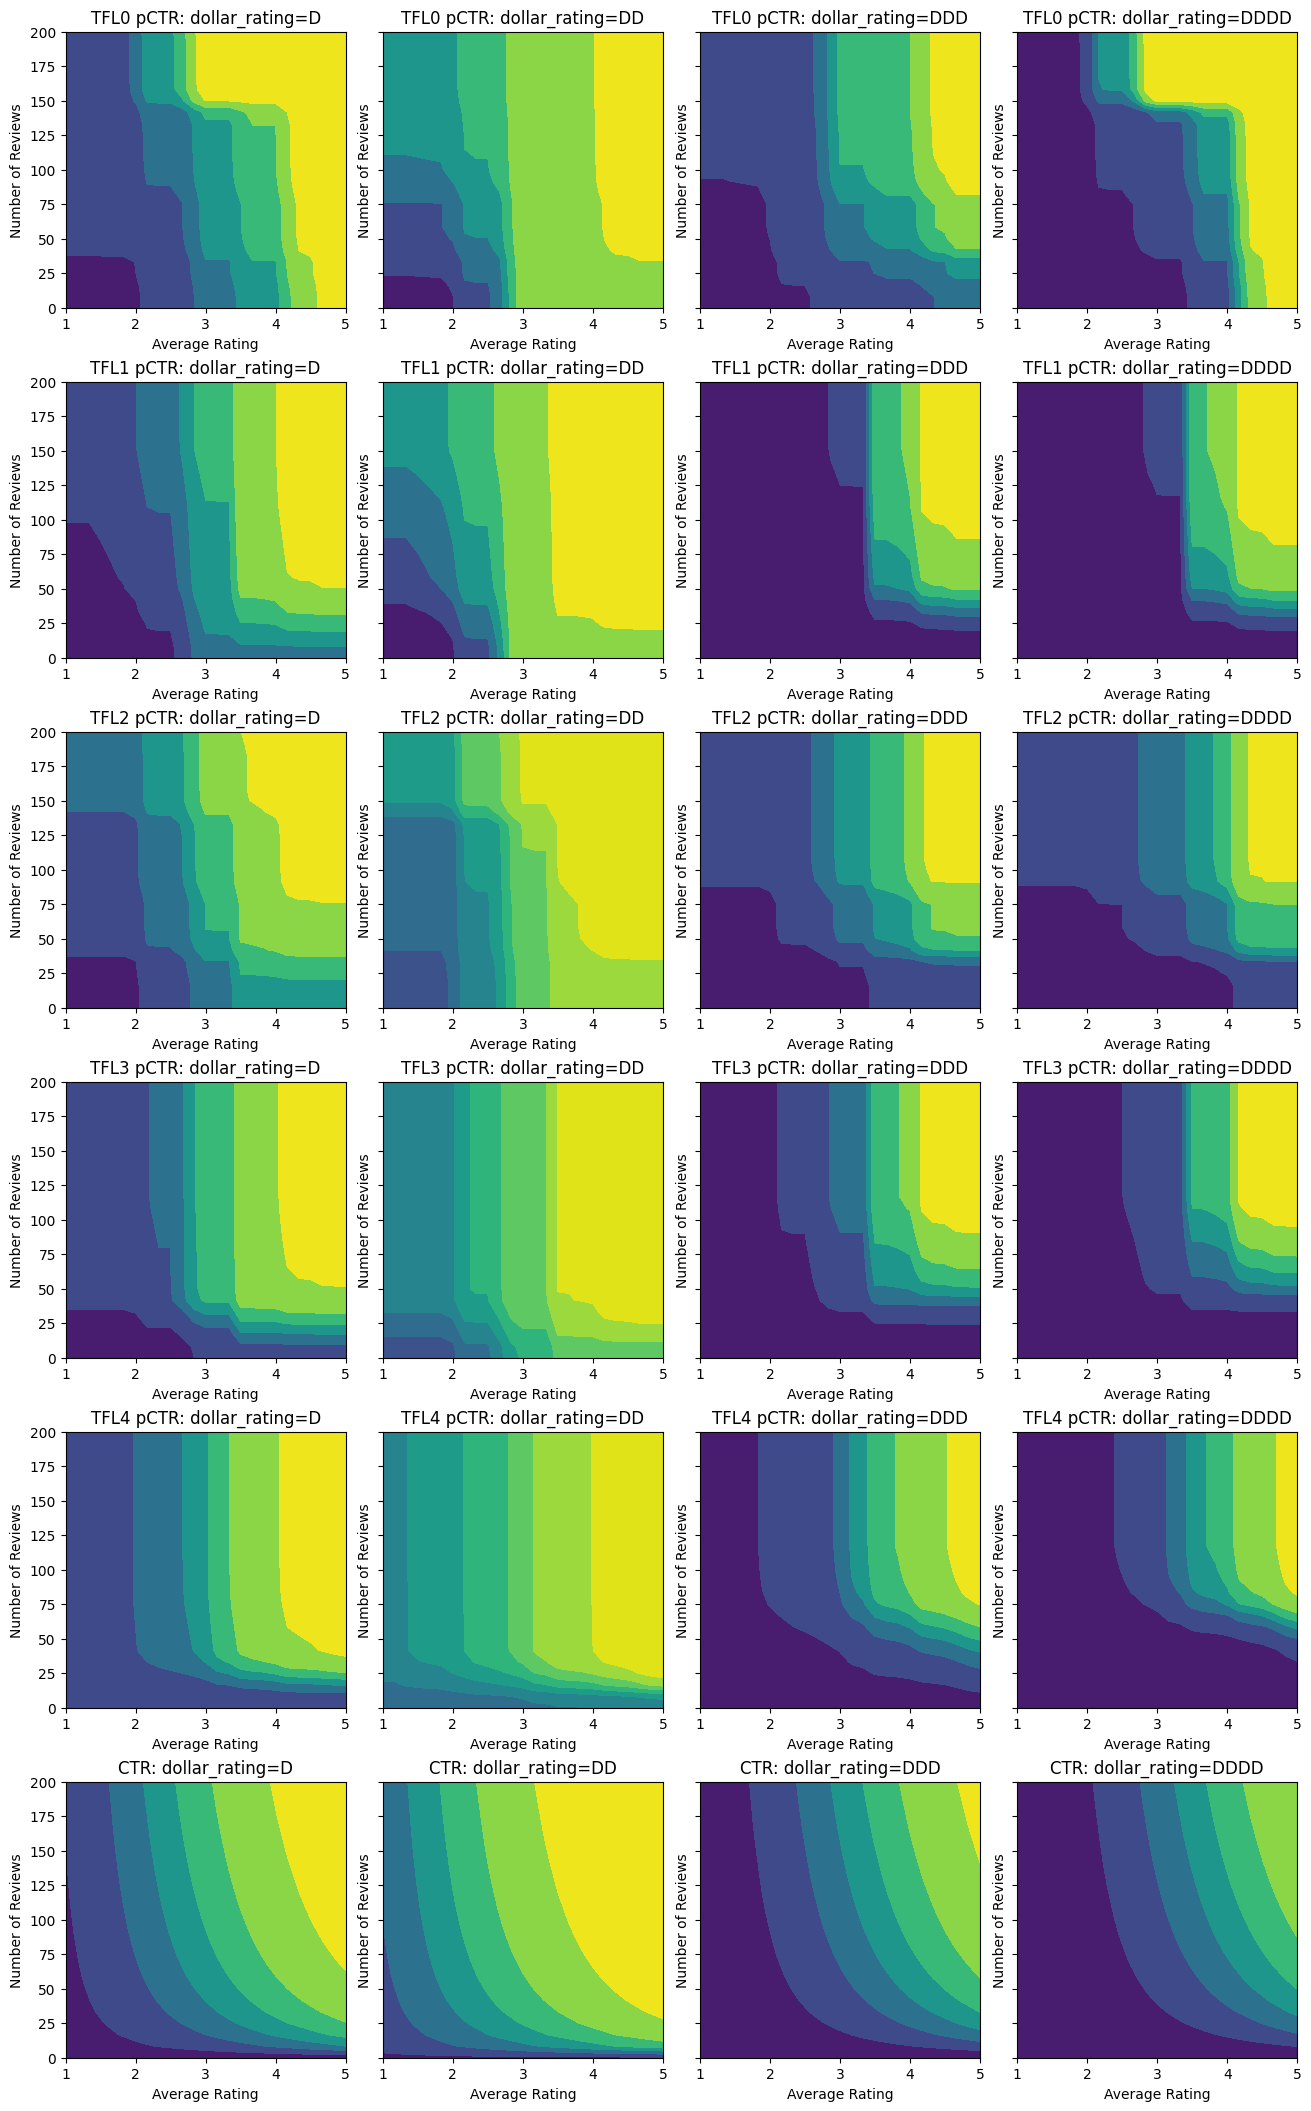

In [23]:
analyze_model(
    [
        (tfl_model_0, "TFL0"),
        (tfl_model_1, "TFL1"),
        (tfl_model_2, "TFL2"),
        (tfl_model_3, "TFL3"),
        (tfl_model_4, "TFL4"),
    ],
    from_logits=True,
    print_metrics=False,
)